In [81]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef, 
    classification_report, precision_recall_fscore_support, 
    confusion_matrix, ConfusionMatrixDisplay
)

In [82]:
# For this model we'll use the 20k dataset no preprocessing
dataset_dir = "/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/"

In [83]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [84]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [85]:
# View the first 20 lines from the dataset text file
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

**In summary, this is the outline of an abstract:**
> - *Abstract Start* -> ###< abstract_id >\n
> - *Abstract Line* -> < TARGET >\t< abstract_text >
> - *Abstract End* -> \n

Now all we need to do is extract this information into a Pandas DataFrame.

In [86]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text 
                
                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature 
                line_data["target"] = target_text_split[0] # get target label
                
                abstract_samples.append(line_data) 

        else: 
            abstract_data += line

    return abstract_samples

In [87]:
%%time
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

CPU times: user 682 ms, sys: 117 ms, total: 799 ms
Wall time: 797 ms


In [88]:
%%time
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

CPU times: user 111 ms, sys: 5.66 ms, total: 116 ms
Wall time: 115 ms


In [89]:
%%time
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

CPU times: user 110 ms, sys: 2.82 ms, total: 113 ms
Wall time: 112 ms


In [90]:
train_count = len(train_samples)
val_count = len(val_samples)
test_count = len(test_samples)
total = train_count + val_count + test_count

In [91]:
print(f'train samples count:\t\t{train_count}')
print(f'dev/validation samples count:\t{val_count}')
print(f'test samples count:\t\t{test_count}')

print(f'\ntotal samples:\t\t\t{total}')

train samples count:		180040
dev/validation samples count:	30212
test samples count:		30135

total samples:			240387


In [92]:
train_samples[:10]

[{'abstract_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,

In [93]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [94]:
train_df.head(20)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS
5,24293578,24293578_5_12,"Serum levels of interleukin 1 ( IL-1 ) , IL-6 ...",5,12,5_12,METHODS
6,24293578,24293578_6_12,There was a clinically relevant reduction in t...,6,12,6_12,RESULTS
7,24293578,24293578_7_12,The mean difference between treatment arms ( 9...,7,12,7_12,RESULTS
8,24293578,24293578_8_12,"Further , there was a clinically relevant redu...",8,12,8_12,RESULTS
9,24293578,24293578_9_12,These differences remained significant at 12 w...,9,12,9_12,RESULTS


<a id=2.3></a>
### Train Data Distribution

In [95]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

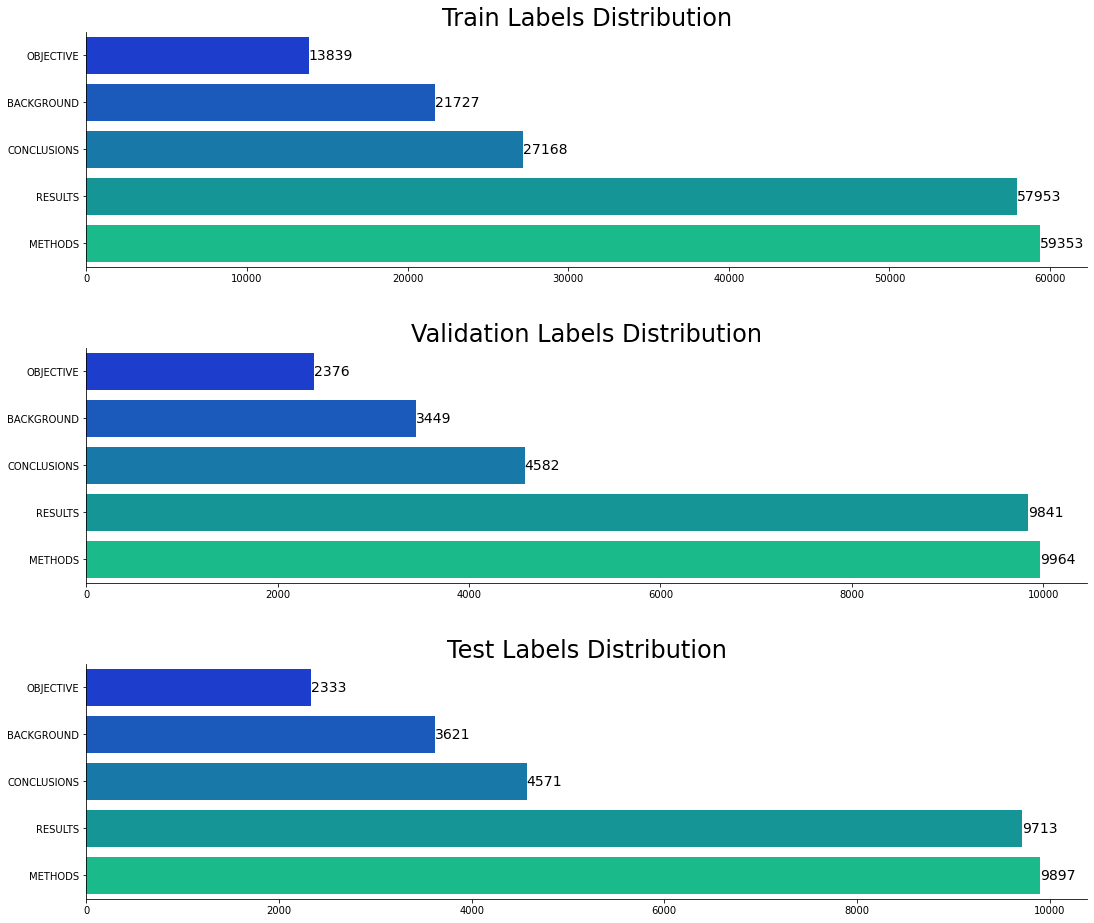

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

fig.tight_layout(pad=6.0)
sns.despine();

ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax1);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax2);
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(
    x=test_distribution.values,
    y=list(test_distribution.keys()),
    orient="h", palette=sns.color_palette("winter", 5),
    ax=ax3);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);


<a id=3.1></a>
### Get Sentences As Lists

In [97]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [98]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		180040
Dev/Validation sample count:	30212
Test sample count:		30135
Total samples:			240387


In [99]:
# View first 5 lines of train sentences
train_sentences[:5]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .']

<a id=3.2></a>
### One-Hot Encode Targets

In [100]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [101]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [102]:
train_df["target"][0]

'OBJECTIVE'

In [103]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

<a id=3.3></a>
### Label Encode Targets

In [104]:
label_encoder = LabelEncoder()

In [105]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# inspect label encoded targets
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [106]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


<a id=3.4></a>
### One-Hot Encode `current_lines`

In [107]:
line_one_hot_encoder = OneHotEncoder(sparse=False)

In [108]:
%%time
train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

CPU times: user 439 ms, sys: 953 ms, total: 1.39 s
Wall time: 1.39 s


In [109]:
test_lines_encoded.shape

(30135, 460)

In [110]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
        
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)        
    ds = ds.batch(batch_size)
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [111]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

In [112]:
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [113]:
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

In [114]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>
Validation Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>
Test Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>


In [115]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [116]:
# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

<a id=5.2></a>
### Define Model Constructor

In [117]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [118]:
def build_model():
    # Model Inputs
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
    abstract_current_line = layers.Input(shape=(460), dtype=tf.float32, name='abstract_current_line')
    
    # Define Layer Initializer
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

In [119]:
model = build_model()

In [120]:
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
abstract_text_input (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   abstract_text_input[0][0]        
__________________________________________________________________________________________________
block_dim_expand (Lambda)       (None, 1, 512)       0           universal_sentence_encoder[0][0] 
__________________________________________________________________________________________________
block_query_lstm (LSTM)         (None, 1, 64)        147712      block_dim_expand[0][0]           
________________________________________________________________________________

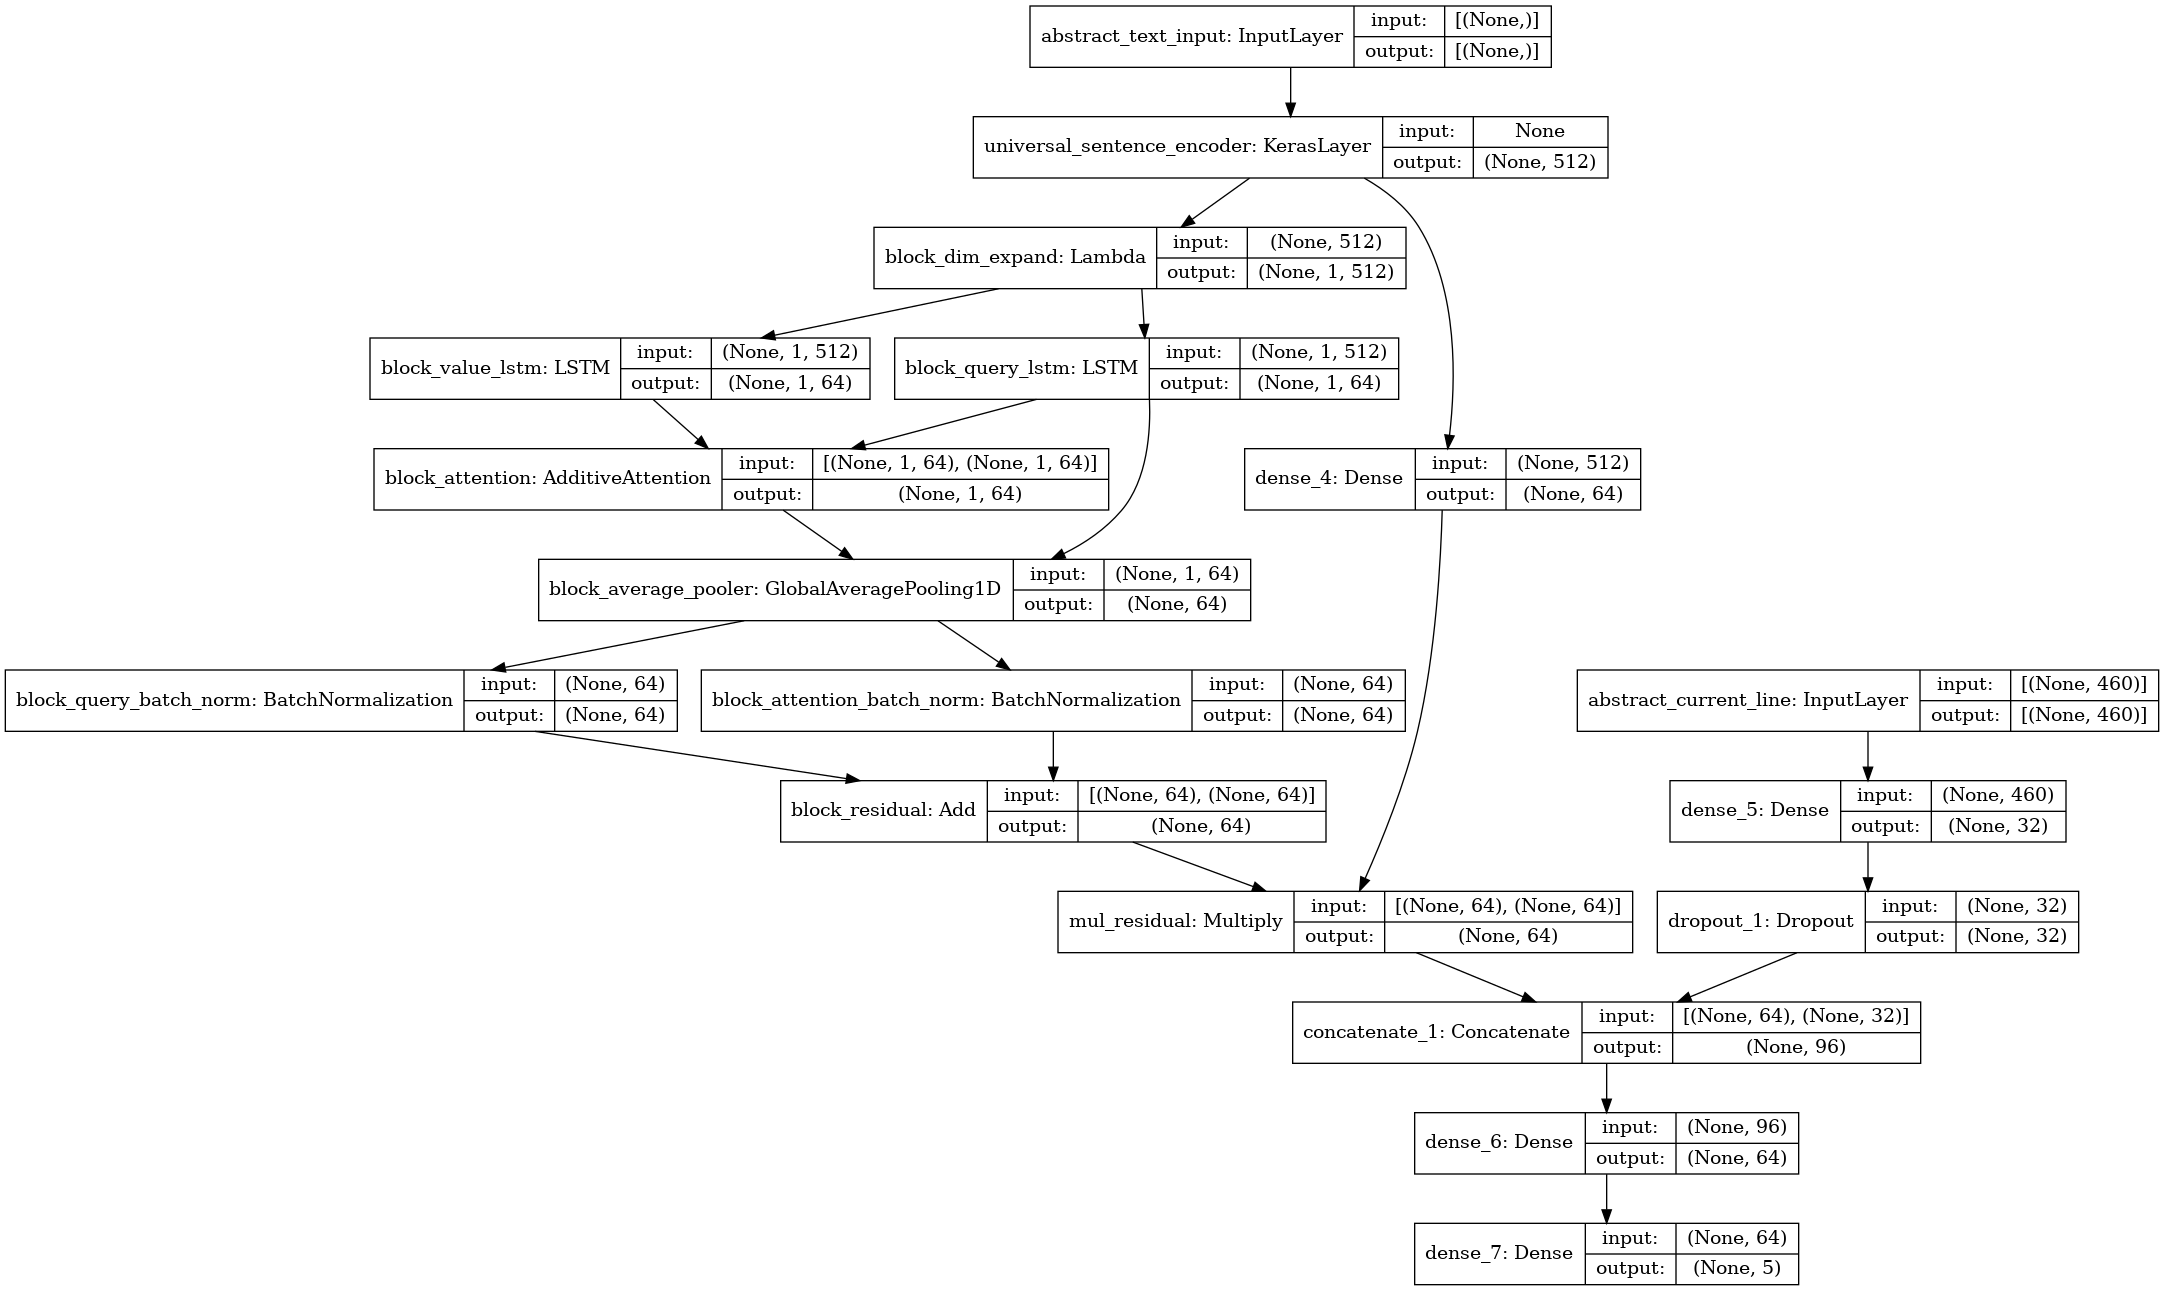

In [121]:
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

In [122]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):

    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [123]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

<a id=6.2></a>
### Compile & Train Model

In [124]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/10
5627/5627 [==============================] - 136s 23ms/step - loss: 0.6921 - accuracy: 0.8500 - val_loss: 0.6366 - val_accuracy: 0.8754
Epoch 2/10
5627/5627 [==============================] - 129s 23ms/step - loss: 0.6303 - accuracy: 0.8792 - val_loss: 0.6249 - val_accuracy: 0.8814
Epoch 3/10
5627/5627 [==============================] - 132s 23ms/step - loss: 0.6117 - accuracy: 0.8885 - val_loss: 0.6235 - val_accuracy: 0.8806
Epoch 4/10
5627/5627 [==============================] - 129s 23ms/step - loss: 0.5968 - accuracy: 0.8963 - val_loss: 0.6294 - val_accuracy: 0.8792
Epoch 5/10
5627/5627 [==============================] - 129s 23ms/step - loss: 0.5842 - accuracy: 0.9026 - val_loss: 0.6344 - val_accuracy: 0.8766

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
5627/5627 [==============================] - 130s 23ms/

In [125]:
model.evaluate(test_ds)

942/942 [==============================] - 11s 12ms/step - loss: 0.6356 - accuracy: 0.8756


[0.6355569958686829, 0.8756263256072998]

In [126]:
# generate validation probabilities
val_probabilities = model.predict(val_ds, verbose=1)
val_probabilities

945/945 [==============================] - 11s 11ms/step


array([[0.79155755, 0.01777224, 0.01897804, 0.156567  , 0.01512517],
       [0.76942396, 0.01868836, 0.00984996, 0.18253328, 0.01950442],
       [0.36398932, 0.02264074, 0.0721764 , 0.48685274, 0.05434082],
       ...,
       [0.01963023, 0.03157924, 0.02672124, 0.01689415, 0.9051751 ],
       [0.0421671 , 0.33218557, 0.02086275, 0.02859303, 0.57619154],
       [0.02390344, 0.939865  , 0.00913546, 0.01749124, 0.00960492]],
      dtype=float32)

In [127]:
# generate validation predictions with argmax
val_predictions = tf.argmax(val_probabilities, axis=1)
val_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

<a id=7.2></a>
### Generate Test Probabilities & Predictions

In [128]:
# generate test probabilities
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

942/942 [==============================] - 11s 11ms/step


array([[0.3492307 , 0.02037697, 0.03870954, 0.57643175, 0.01525101],
       [0.1663639 , 0.04058183, 0.44300202, 0.19111075, 0.15894154],
       [0.02316091, 0.02665644, 0.8265483 , 0.02043627, 0.10319815],
       ...,
       [0.01005223, 0.03682239, 0.01174317, 0.00940596, 0.9319762 ],
       [0.03283932, 0.12069105, 0.01877791, 0.01970075, 0.807991  ],
       [0.02217662, 0.9286129 , 0.00709251, 0.01561354, 0.02650434]],
      dtype=float32)

In [129]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

<a id=7.3></a>
### Plot Model History

In [130]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

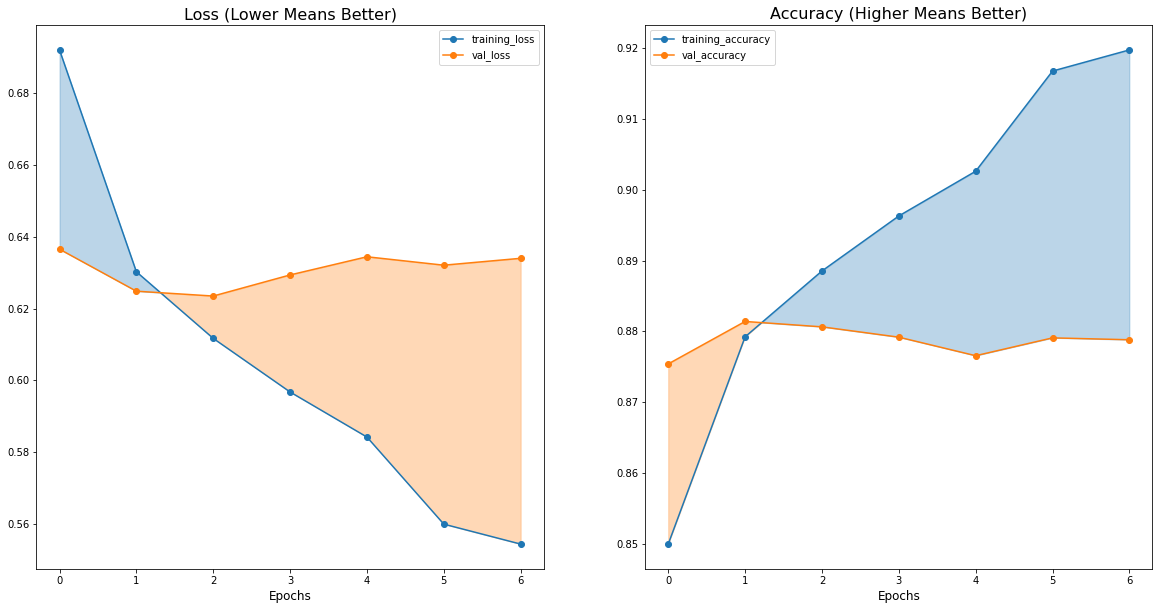

In [131]:
plot_training_curves(model_history)

In [132]:
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.71      0.85      0.77      3449
 CONCLUSIONS       0.93      0.91      0.92      4582
     METHODS       0.91      0.93      0.92      9964
   OBJECTIVE       0.78      0.52      0.62      2376
     RESULTS       0.91      0.92      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.85      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212



In [133]:
print(classification_report(test_labels_encoded, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.73      0.84      0.78      3621
 CONCLUSIONS       0.93      0.91      0.92      4571
     METHODS       0.90      0.93      0.92      9897
   OBJECTIVE       0.77      0.51      0.62      2333
     RESULTS       0.91      0.90      0.91      9713

    accuracy                           0.88     30135
   macro avg       0.85      0.82      0.83     30135
weighted avg       0.88      0.88      0.87     30135



<a id=7.5></a>
### Inspect Validation Performance

In [134]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels_encoded, 
                                                                                 test_predictions, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return

In [135]:
generate_preformance_scores(val_labels_encoded, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.88064

_____________________________________________
top_3_accuracy_score:	0.99583

_____________________________________________
precision_score:	0.87577

_____________________________________________
recall_score:		0.87563

_____________________________________________
f1_score:		0.87297

_____________________________________________
matthews_corrcoef:	0.83948



<a id=7.6></a>
### Inspect Test Performance

In [136]:
generate_preformance_scores(test_labels_encoded, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.87563

_____________________________________________
top_3_accuracy_score:	0.99516

_____________________________________________
precision_score:	0.87577

_____________________________________________
recall_score:		0.87563

_____________________________________________
f1_score:		0.87297

_____________________________________________
matthews_corrcoef:	0.83299



In [137]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=11): 

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=figsize)

    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size},
        fmt='d',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    
    plt.show()
    
    return

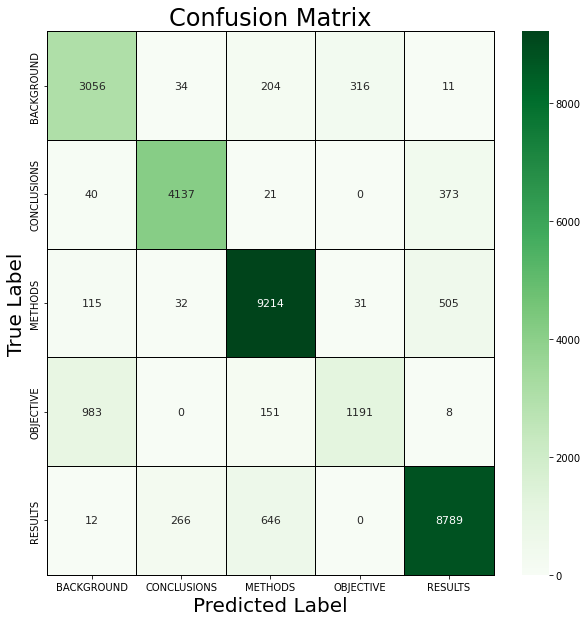

In [138]:
# View Confusion Matrix
plot_confusion_matrix(
    test_labels_encoded, 
    test_predictions, 
    figsize=(10, 10), 
    classes=list(class_names))

In [139]:
test_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS
...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS


In [140]:
top_3_values, top_3_indices = tf.nn.top_k(test_probabilities, k=3)

In [141]:
%%time

test_pred_df = test_df.copy()

# add best predictions
test_pred_df['prediction'] = [class_names[_] for _ in top_3_indices[:, 0]]
test_pred_df['probability'] = list(top_3_values[:, 0].numpy())

# add 2nd best predictions
test_pred_df['prediction_2'] = [class_names[_] for _ in top_3_indices[:, 1]]
test_pred_df['probability_2'] = list(top_3_values[:, 1].numpy())

# add 3rd best predictions
test_pred_df['prediction_3'] = [class_names[_] for _ in top_3_indices[:, 2]]
test_pred_df['probability_3'] = list(top_3_values[:, 2].numpy())

CPU times: user 14.5 s, sys: 0 ns, total: 14.5 s
Wall time: 14.5 s


In [142]:
test_pred_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND,OBJECTIVE,0.576432,BACKGROUND,0.349231,METHODS,0.038710
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS,METHODS,0.443002,OBJECTIVE,0.191111,BACKGROUND,0.166364
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS,METHODS,0.826548,RESULTS,0.103198,CONCLUSIONS,0.026656
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS,RESULTS,0.645693,METHODS,0.277482,CONCLUSIONS,0.030680
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS,RESULTS,0.814605,METHODS,0.129112,CONCLUSIONS,0.022249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS,RESULTS,0.929724,CONCLUSIONS,0.018166,BACKGROUND,0.018054
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS,RESULTS,0.946167,CONCLUSIONS,0.023863,OBJECTIVE,0.011353
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS,RESULTS,0.931976,CONCLUSIONS,0.036822,METHODS,0.011743
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS,RESULTS,0.807991,CONCLUSIONS,0.120691,BACKGROUND,0.032839


In [143]:
def view_prediction(pred_df, sample_index):
    sample = pred_df.iloc[sample_index]
    
    print('====================================================')
    print(f'id:\t\t{sample.abstract_id}')
    print('____________________________________________________')
    print(f'text:\n\n{sample.abstract_text}')
    print('____________________________________________________')
    print(f'current_line:\t{sample.current_line}')
    print('____________________________________________________')
    print(f'target:\t\t{sample.target}')
    print('____________________________________________________')
    print(f'predictions:\n')
    print(f'1: {sample.prediction}({sample.probability})')
    print(f'2: {sample["prediction_2"]}({sample["probability_2"]})')
    print(f'3: {sample["prediction_3"]}({sample["probability_3"]})')
    print('====================================================')
    
    return

<a id=7.9></a>
### Inspect Least Accurate Predictions

In [144]:
least_accurate = test_pred_df.loc[test_pred_df.target == test_pred_df.prediction].sort_values('probability', inplace=False)

In [145]:
least_accurate.head(5).T

,27393,9480,18760,7320,230
abstract_id,25769361,24934642,25494622,24610399,26135348
line_id,25769361_2_22,24934642_9_14,25494622_8_17,24610399_7_10,26135348_2_10
abstract_text,"In the ENGAGE AF-TIMI 48 trial , higher-dose a...",Development of instruments .,The physical activity intervention is framed a...,"Proxy measures of cessation readiness ( e.g. ,...",We assessed whether increased dietary nitrate ...
line_number,2,9,8,7,2
total_lines,22,14,17,10,10
current_line,2_22,9_14,8_17,7_10,2_10
target,BACKGROUND,METHODS,METHODS,RESULTS,OBJECTIVE
prediction,BACKGROUND,METHODS,METHODS,RESULTS,OBJECTIVE
probability,0.279268,0.295752,0.312786,0.324017,0.32423
prediction_2,RESULTS,CONCLUSIONS,CONCLUSIONS,METHODS,METHODS


In [146]:
view_prediction(least_accurate, 0)

id:		25769361
____________________________________________________
text:

In the ENGAGE AF-TIMI 48 trial , higher-dose and lower-dose edoxaban were compared with warfarin in patients with atrial fibrillation .
____________________________________________________
current_line:	2_22
____________________________________________________
target:		BACKGROUND
____________________________________________________
predictions:

1: BACKGROUND(0.2792683243751526)
2: RESULTS(0.2677086293697357)
3: METHODS(0.23791678249835968)


In [147]:
view_prediction(least_accurate, 1)

id:		24934642
____________________________________________________
text:

Development of instruments .
____________________________________________________
current_line:	9_14
____________________________________________________
target:		METHODS
____________________________________________________
predictions:

1: METHODS(0.2957516014575958)
2: CONCLUSIONS(0.23077178001403809)
3: RESULTS(0.20946389436721802)


In [148]:
wild_abstract_text = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by 
regulating vascular cell motility. Our analysis identifies and systematically characterizes >250 risk 
loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD."""

In [149]:
# view the abstract
print(wild_abstract_text)

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer

In [150]:
wild_abstract_preprocessed = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .
We detected 241 associations, including 30 new loci . 
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approaches .
Using CRISPR–Cas9, we experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by regulating vascular cell motility .
Our analysis identifies and systematically characterizes >250 risk loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD ."""

In [151]:
wild_texts = [_  for _ in wild_abstract_preprocessed.split('\n')]

wild_texts = np.array(wild_texts).reshape((len(wild_texts), 1))
wild_texts.shape

(9, 1)

In [152]:
wild_texts

array([['The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .'],
       ['Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .'],
       ['We detected 241 associations, including 30 new loci . '],
       ['Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .'],
       ['We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .'],
       ['Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .'],
       ['We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approa

In [153]:
wild_current_lines = [f'{_}_{len(wild_texts)}' for _ in range(len(wild_texts))]
print(wild_current_lines)

['0_9', '1_9', '2_9', '3_9', '4_9', '5_9', '6_9', '7_9', '8_9']


In [154]:
wild_current_lines_transformed = line_one_hot_encoder.transform(np.array(wild_current_lines).reshape(-1, 1))
wild_current_lines_transformed.shape

(9, 460)

<a id=8.2></a>
### Generate Probabilities

In [155]:
wild_probabilities = model.predict((wild_texts, (wild_current_lines_transformed)), verbose=1)
wild_probabilities

1/1 [==============================] - 1s 777ms/step


array([[0.79723614, 0.01466058, 0.01635903, 0.15723608, 0.0145082 ],
       [0.07157639, 0.02801892, 0.77195656, 0.07632889, 0.05211917],
       [0.03819222, 0.02632117, 0.5000175 , 0.03928809, 0.39618102],
       [0.03445805, 0.02837816, 0.6623398 , 0.02598605, 0.24883789],
       [0.03382625, 0.02908358, 0.4994293 , 0.03910322, 0.39855772],
       [0.02485218, 0.04299979, 0.39327508, 0.0308237 , 0.5080493 ],
       [0.03100727, 0.09483032, 0.11252566, 0.03212702, 0.7295097 ],
       [0.03152994, 0.8169872 , 0.04230992, 0.02986845, 0.0793045 ],
       [0.01678282, 0.9258368 , 0.01632919, 0.02264335, 0.0184079 ]],
      dtype=float32)

<a id=8.3></a>
### View Wild Abstract Predictions

In [156]:
def view_wild_prediction(texts, current_lines, probabilities):
    for text, current_line, prob in zip(texts, current_lines, probabilities):
        top_3_probs, top_3_labels = tf.nn.top_k(prob, k=3)
        predicted_labels = [class_names[_] for _ in top_3_labels]
        print(f'Text:\n\n{text[0]}\n')
        print(f'Predictions:\n')
        print(f'1: {predicted_labels[0]}({top_3_probs[0]:.6f})')
        print(f'2: {predicted_labels[1]}({top_3_probs[1]:.6f})')
        print(f'3: {predicted_labels[2]}({top_3_probs[2]:.6f})')
        print('====================================================')
    
    return

In [157]:
view_wild_prediction(wild_texts, wild_current_lines, wild_probabilities)

Text:

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .

Predictions:

1: BACKGROUND(0.797236)
2: OBJECTIVE(0.157236)
3: METHODS(0.016359)
Text:

Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .

Predictions:

1: METHODS(0.771957)
2: OBJECTIVE(0.076329)
3: BACKGROUND(0.071576)
Text:

We detected 241 associations, including 30 new loci . 

Predictions:

1: METHODS(0.500018)
2: RESULTS(0.396181)
3: OBJECTIVE(0.039288)
Text:

Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .

Predictions:

1: METHODS(0.662340)
2: RESULTS(0.248838)
3: BACKGROUND(0.034458)
Text:

We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .

Predictions:

1: METHODS(

<a id=8.4></a>
### View the segmented abstract in color

In [158]:
def display_segemented_abstract(abstract_texts, labels, color=False):
    colors = {
        'BACKGROUND': 34,     # blue
        'OBJECTIVE': 35,      # magenta
        'METHODS': 32,        # green
        'RESULTS': 33,        # yellow
        'CONCLUSIONS': 31     # red
    }
    
    segmented_abstract = ""
    
    for text_line, text_label in zip(abstract_texts, labels):
        if color:
            segmented_abstract += '\033[1;{}m{:<12s}\n{:<12s}\n\n'.format(colors[text_label], text_label, text_line[0])
        else:
            segmented_abstract += '{:<12s}\n {:<12s}\n'.format(text_label, text_line[0])
            
    return segmented_abstract

In [159]:
wild_predictions = np.argmax(wild_probabilities, axis=1)
wild_labels = [class_names[_] for _ in wild_predictions]

In [160]:
wild_segmented_abstract = display_segemented_abstract(wild_texts, wild_labels, color=True)
print(wild_segmented_abstract)

BACKGROUND  
The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .

METHODS     
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .

METHODS     
We detected 241 associations, including 30 new loci . 

METHODS     
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .

METHODS     
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .

RESULTS     
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .

RESULTS     
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by thre